## 0. Load package

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from operator import itemgetter

## **1. Data Preparing**

### 1.1 Divide the scoring data into training set, validation set and test set according to the ratio of 80%, 10%, and 10%

In [2]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')

ratings.sample(frac=1.0)
train_set, test_set = train_test_split(ratings,test_size = 0.2)
dev_set, test_set = train_test_split(test_set,test_size = 0.5)
train_set = np.array(train_set, dtype = 'int')
dev_set = np.array(dev_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [3]:
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
print(train_set.shape)
print(dev_set.shape)
print(test_set.shape)

(800167, 4)
(100021, 4)
(100021, 4)


### 1.2 Convert the data into a list form ([ [User 1 rating of all movies], [User 2 rating of all movies] ...], and set the ratings of movies that the user has not rated to 0

In [5]:
nb_users = int(max(max(train_set[:,0]), max(dev_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(train_set[:,1]), max(dev_set[:,1]), max(test_set[:,1])))

# Converting the data into an array with users in lines and movies in columns
def convert(data):
    new_data = []
    #Match the user and movie in the corresponding local data. If the user has not evaluated the movie, then mark ‘0
    for id_users in range(1, nb_users + 1):
        #create The first level list, id_movies is the id of the movie that a user has seen
        id_movies = data[:,1][data[:,0] == id_users]
        #id_ratingsRate the rate of a movie for a user
        id_ratings = data[:,2][data[:,0] == id_users]
        #First create a list of all 0s, and then replace the rating score of the movie that the user evaluates with 0, then you can mark the movie that the user has not seen as 0
        ratings = np.zeros(nb_movies)
        #Because movieID starts from 1, and python starts from 0, so if you want rating to match python, -1
        ratings[id_movies - 1] = id_ratings
        #Merge the list created above into a list to be extracted by torch
        new_data.append(list(ratings))
    return new_data
    
train_set = convert(train_set)
dev_set = convert(dev_set)
test_set = convert(test_set)

### 1.3 Data loading pytorch comes with DataLoader

In [6]:
train_set = torch.FloatTensor(train_set)
train_set = train_set[torch.sum(train_set!=0,axis=1)!=0] # Delete rows with all 0 ratings
dev_set = torch.FloatTensor(dev_set)
dev_set = dev_set[torch.sum(dev_set!=0,axis=1)!=0] # Delete rows with all 0 ratings
test_set = torch.FloatTensor(test_set)
test_set = test_set[torch.sum(test_set!=0,axis=1)!=0] # Delete rows with all 0 ratings

train_dataset = TensorDataset(train_set)
dev_dataset = TensorDataset(dev_set)
test_dataset = TensorDataset(test_set)

train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
dev_loader = DataLoader(dataset = dev_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

## **2. Auto Encoder**

### 2.1 Define the model and loss function

In [7]:
class AE(nn.Module):
  """
  Auto Encoder (AE) was originally used to learn the representation (encoding) of data. It can be broken down into two parts:

  encoder: Reduce the dimensionality of the data;
  decoder: It converts the encoding back to its original form. Due to the dimensionality reduction, the neural network needs to learn a low-dimensional representation of the input (latent space) in order to be able to reconstruct the input.

  They can be used to predict new recommendations. In order to do this, the input and output are both click vectors (usually the input and output of AE are the same), we will use a large dropout after the input layer.
  This means that the model will have to reconstruct the click vector, because an element in the input will be lost, so it has to learn to predict the recommended value of a given click vector.
  """
  def __init__(self, nb_movies, device="cuda:0"):
    super(AE, self).__init__()
    self.nb_movies = nb_movies
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_movies, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9),
        nn.Linear(512, 80),
        nn.Sigmoid(),
        nn.Linear(80, 32),
        nn.Sigmoid()
        )
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_movies)
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

def loss_func(recon_x, x):
  """
  For a user, he only scored some movies, so when calculating MSE, only consider the movies he has rated, and ignore the movies he has not rated.
  The calculation principle of MSE here is, for example, the scoring data of 5 movies by 2 users is: [[1, 2, 0, 3, 4], [2, 3, 0, 0, 1]]
  The scoring data after AE reconstruction is: [[1.1, 2.3, 0, 3.3, 4.7], [2.1, 3.2, 0, 0, 1.2]]
  Then first calculate the square of the 2 norm of the two scoring data, and then divide by the number of movies that each user has rated to get the MSE of each user, and then use torch.mean to average to get the MSE of each batch
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  return MSE

### 2.2 Define training, validation and testing functions

In [8]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  ae.train()
  total_loss = 0
  for _, data in enumerate(train_loader, 0):
    data = Variable(data[0]).to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x = ae.forward(data)
    # In the optimization process, we only want to consider the movies that users have rated,
    # Although we previously set the ratings of unrated movies by users to 0, we also need to set the ratings of unrated movies predicted by the model to 0.
    # This will not accumulate to the loss, which will affect the weight update
    recon_x[target == 0] = 0 
    loss = loss_func(recon_x, data)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    ae.eval()
    total_loss = 0
    with torch.no_grad():
      for _, data in enumerate(dev_loader, 0):
        data = Variable(data[0]).to(device)
        target = data.clone()
        recon_x = ae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

def test(test_loader, device="cuda:0"):
  ae.eval()
  total_loss = 0
  with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
      data = Variable(data[0]).to(device)
      target = data.clone()
      recon_x = ae.forward(data)
      recon_x[target == 0] = 0
      loss = loss_func(recon_x, data)
      total_loss += loss.item()
  print('Average test loss: {:.4f}'.format(total_loss / len(test_loader)))

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  ae = AE(nb_movies = nb_movies).to(device)
  optimizer =  optim.Adam(ae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 200
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = dev_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)
  print("\n", 20 * "=", "Testing Auto Encoder on device: {}".format(device), 20 * "=")
  test(test_loader)


 ==================== Training Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 3.8532, Validating Average loss: 1.0675
====> Epoch: 2 Training Average loss: 1.0200, Validating Average loss: 1.0205
====> Epoch: 3 Training Average loss: 0.9981, Validating Average loss: 1.0166
====> Epoch: 4 Training Average loss: 0.9962, Validating Average loss: 1.0152
====> Epoch: 5 Training Average loss: 0.9956, Validating Average loss: 1.0189
====> Epoch: 6 Training Average loss: 0.9956, Validating Average loss: 1.0162
====> Epoch: 7 Training Average loss: 0.9954, Validating Average loss: 1.0164
====> Epoch: 8 Training Average loss: 0.9947, Validating Average loss: 1.0198
====> Epoch: 9 Training Average loss: 0.9941, Validating Average loss: 1.0193
====> Epoch: 10 Training Average loss: 0.9939, Validating Average loss: 1.0168
====> Epoch: 11 Training Average loss: 0.9924, Validating Average loss: 1.0214
====> Epoch: 12 Training Average loss: 0.9915, Validatin

====> Epoch: 104 Training Average loss: 0.8879, Validating Average loss: 1.0470
====> Epoch: 105 Training Average loss: 0.8884, Validating Average loss: 1.0391
====> Epoch: 106 Training Average loss: 0.8852, Validating Average loss: 1.0436
====> Epoch: 107 Training Average loss: 0.8877, Validating Average loss: 1.0462
====> Epoch: 108 Training Average loss: 0.8856, Validating Average loss: 1.0462
====> Epoch: 109 Training Average loss: 0.8851, Validating Average loss: 1.0384
====> Epoch: 110 Training Average loss: 0.8856, Validating Average loss: 1.0424
====> Epoch: 111 Training Average loss: 0.8846, Validating Average loss: 1.0456
====> Epoch: 112 Training Average loss: 0.8847, Validating Average loss: 1.0387
====> Epoch: 113 Training Average loss: 0.8846, Validating Average loss: 1.0385
====> Epoch: 114 Training Average loss: 0.8821, Validating Average loss: 1.0459
====> Epoch: 115 Training Average loss: 0.8791, Validating Average loss: 1.0414
====> Epoch: 116 Training Average loss: 

### 2.3 Save and load models

In [9]:
# save the training model
torch.save(ae.state_dict(), 'AutoEncoder.pkl')

# load the trained model
ae = torch.load('AutoEncoder.pkl')

### 2.4 Plot a graph to show the loss change in the training and verification process: It can be found that the loss of the verification set has dropped first and then rises slightly. It is considered that the model is over-fitting + poor generalization ability

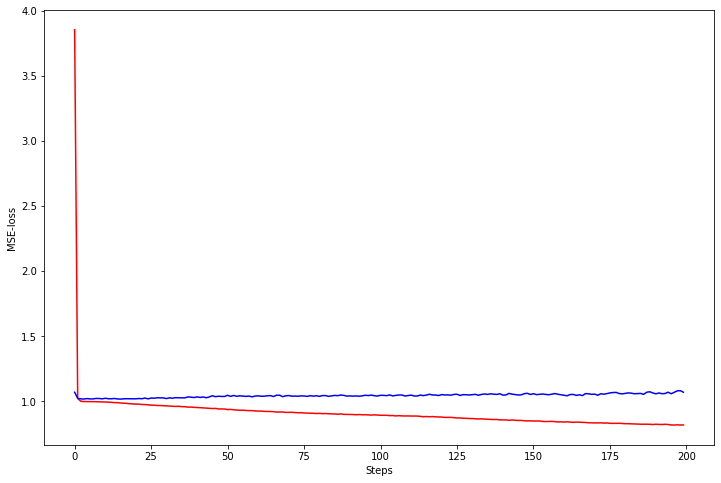

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.show()


## **3. Variational Auto Encoder**

### 3.1 Define the model and loss function

In [13]:
class VAE(nn.Module):

  def __init__(self, nb_movies, device="cuda:0"):
    super(VAE, self).__init__()
    self.nb_movies = nb_movies
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_movies, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9), # Need a larger dropout
        nn.Linear(512, 80),
        nn.Sigmoid()
        )
    self.fc1 = nn.Linear(80, 32)
    self.fc2 = nn.Linear(80, 32)
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_movies)
        )
    
  # reparameterize
  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size(0), mu.size(1))).to(device)
    z = mu + eps * torch.exp(logvar/2) 
    return z

  def forward(self, x):
    out1, out2 = self.encoder(x), self.encoder(x)
    mu = self.fc1(out1)
    logvar = self.fc2(out2)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

def loss_func(recon_x, x, mu, logvar):
  """
  The loss of VAE includes two parts:
  One part is the average absolute error between the predicted result and the true result;
  The other part is KL-divergence (KL divergence), which is used to measure the difference between the distribution of latent variables and the unit Gaussian distribution.
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD

### 3.2 Define training, validation and testing functions

In [14]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  vae.train()
  total_loss = 0
  for _, data in enumerate(train_loader, 0):
    data = Variable(data[0]).to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x, mu, logvar = vae.forward(data)
    recon_x[target == 0] = 0
    loss = loss_func(recon_x, data, mu, logvar)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
      for _, data in enumerate(dev_loader, 0):
        data = Variable(data[0]).to(device)
        target = data.clone()
        recon_x, mu, logvar = vae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data, mu, logvar)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

def test(test_loader, device="cuda:0"):
  vae.eval()
  total_loss = 0
  with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
      data = Variable(data[0]).to(device)
      target = data.clone()
      recon_x, mu, logvar = vae.forward(data)
      recon_x[target == 0] = 0
      loss = loss_func(recon_x, data, mu, logvar)
      total_loss += loss.item()
  print('Average test loss: {:.4f}'.format(total_loss / len(test_loader)))

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  vae = VAE(nb_movies = nb_movies).to(device)
  optimizer =  optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 200
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Variational Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = dev_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)
  print("\n", 20 * "=", "Testing Variational Auto Encoder on device: {}".format(device), 20 * "=")
  test(test_loader)


 ==================== Training Variational Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 7.8470, Validating Average loss: 1.5987
====> Epoch: 2 Training Average loss: 2.1356, Validating Average loss: 1.3609
====> Epoch: 3 Training Average loss: 1.6246, Validating Average loss: 1.1745
====> Epoch: 4 Training Average loss: 1.3480, Validating Average loss: 1.0744
====> Epoch: 5 Training Average loss: 1.1938, Validating Average loss: 1.0363
====> Epoch: 6 Training Average loss: 1.1162, Validating Average loss: 1.0301
====> Epoch: 7 Training Average loss: 1.0769, Validating Average loss: 1.0296
====> Epoch: 8 Training Average loss: 1.0543, Validating Average loss: 1.0327
====> Epoch: 9 Training Average loss: 1.0384, Validating Average loss: 1.0309
====> Epoch: 10 Training Average loss: 1.0283, Validating Average loss: 1.0271
====> Epoch: 11 Training Average loss: 1.0199, Validating Average loss: 1.0290
====> Epoch: 12 Training Average loss: 1.014

====> Epoch: 104 Training Average loss: 0.9810, Validating Average loss: 1.0054
====> Epoch: 105 Training Average loss: 0.9807, Validating Average loss: 1.0072
====> Epoch: 106 Training Average loss: 0.9810, Validating Average loss: 1.0056
====> Epoch: 107 Training Average loss: 0.9813, Validating Average loss: 1.0074
====> Epoch: 108 Training Average loss: 0.9809, Validating Average loss: 1.0083
====> Epoch: 109 Training Average loss: 0.9806, Validating Average loss: 1.0063
====> Epoch: 110 Training Average loss: 0.9807, Validating Average loss: 1.0081
====> Epoch: 111 Training Average loss: 0.9809, Validating Average loss: 1.0082
====> Epoch: 112 Training Average loss: 0.9802, Validating Average loss: 1.0084
====> Epoch: 113 Training Average loss: 0.9799, Validating Average loss: 1.0081
====> Epoch: 114 Training Average loss: 0.9806, Validating Average loss: 1.0086
====> Epoch: 115 Training Average loss: 0.9802, Validating Average loss: 1.0058
====> Epoch: 116 Training Average loss: 

### 3.3 Plot a graph to show the loss change in the training and verification process. It is found that although the training loss of VAE is larger than AE, the validating loss and test loss are smaller than AE. The consideration is because the training loss of VAE contains two parts, so the training loss is too large; but the VAE model may capture more complex patterns in the data, making it perform better on the validation set and test set. 

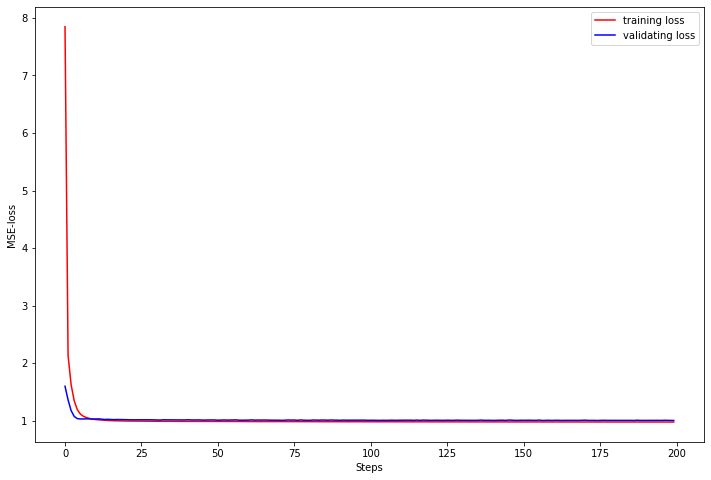

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.legend()

## **4. Use the model to predict the movies that the user has not rated, and according to the predicted scores, recommend movies that the user has not watched**

### 4.1 Define the prediction function

In [16]:
#prediction
def Prediction(model, movies, user_id, nb_recommend):
    user_input = Variable(test_set[user_id - 1]).unsqueeze(0).to(device)
    predict_output, _, _ = model.forward(user_input)
    predict_output = predict_output.cpu().detach().numpy()
    user_input = user_input.cpu().detach().numpy()
    predicted_result = np.vstack([user_input, predict_output])
    recommend = np.array(predicted_result)
    trian_movie_id = np.array([i for i in range(1, nb_movies+1)]) #create a temporary index for movies since we are going to delete some movies that the user had seen
    recommend = np.row_stack((recommend, trian_movie_id)) #insert that index into the result array, 
    recommend = recommend.T #transpose row and col Invert the rows and columns of the array
    recommend = recommend.tolist() #tansfer into list for further process

    movie_not_seen = [] #delete the rows comtaining the movies that the user had seen
    for i in range(len(recommend)):
        if recommend[i][0] == 0.0:
            movie_not_seen.append(recommend[i])

    movie_not_seen = sorted(movie_not_seen, key=itemgetter(1), reverse=True) #sort the movies by mark Sort the movies in descending order according to the predicted score

    recommend_movie = [] #create list for recommended movies with the index we created recommended top20
    for i in range(0, nb_recommend):
        recommend_movie.append(movie_not_seen[i][2])

    recommend_index = [] #get the real index in the original file of'movies.dat' by using the temporary index
    for i in range(len(recommend_movie)):
        recommend_index.append(movies[(movies.iloc[:,0]==recommend_movie[i])].index.tolist())

    recommend_movie_name = [] #get a list of movie names using the real indexEnter the corresponding index and export the movie names
    for i in range(len(recommend_index)):
        np_movie = movies.iloc[recommend_index[i],1].values #transefer to np.array
        list_movie = np_movie.tolist() #transfer to list
        recommend_movie_name.append(list_movie)

    print('Highly Recommended Moives for You:\n')
    for i in range(len(recommend_movie_name)):
        print(str(recommend_movie_name[i]))
    
    return recommend_movie_name

### 4.2 To the designated user, recommend his most likely favorite movies from the movies he hasn’t watched

In [27]:
# Specify the user's ID
user_id = 86
# Specify the number of recommended movies
nb_recommend = 20
# Read the original movie data for query when recommending
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

# Use VAE model for prediction recommendation
movie_for_you = Prediction(model = vae, movies = movies, user_id = user_id, nb_recommend = nb_recommend)

Highly Recommended Moives for You:

['Callejón de los milagros, El (1995)']
['Lured (1947)']
['Modulations (1998)']
['Return with Honor (1998)']
['Song of Freedom (1936)']
['Lamerica (1994)']
['Follow the Bitch (1998)']
['Bittersweet Motel (2000)']
['One Little Indian (1973)']
['Skipped Parts (2000)']
['Eighth Day, The (Le Huitième jour ) (1996)']
['Zachariah (1971)']
['Smashing Time (1967)']
['Window to Paris (1994)']
['Hour of the Pig, The (1993)']
['Ulysses (Ulisse) (1954)']
['Soft Fruit (1999)']
['Firelight (1997)']
['Gate of Heavenly Peace, The (1995)']
['Sanjuro (1962)']
